This notebook contains the plotting functions used to plot the results of the meta-analysis with interaction terms (Supplementary Figures 5,6).

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
from matplotlib import colors, patches
import seaborn as sns
import logging, warnings

/home/icb/malte.luecken/anaconda3/envs/cov19_py/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 35)
warnings.filterwarnings("ignore", category=DeprecationWarning, module="tensorflow")

scanpy==1.4.5.1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.1 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [3]:
#User inputs
folder = '/storage/groups/ml01/workspace/malte.luecken/2020_cov19_study'

output_folder = 'diffxpy_out/'

base = 'COVID19_lung_atlas_revision_v3_lung_cov19_poissonglm_smoking'

In [4]:
res_lvl2 = pd.read_csv(folder+'/'+output_folder+base+'_nUMIoffset_testInts_lvl2_full.csv', index_col=0)
res_lvl2_ho = pd.read_csv(folder+'/'+output_folder+base+'_holdouts_nUMIoffset_testInts_lvl2_full.csv', index_col=0)
res_lvl2_ho_summary = pd.read_csv(folder+'/'+output_folder+base+'_holdouts_nUMIoffset_testInts_lvl2_summary.csv', index_col=0)
res_lvl2_pseudo = pd.read_csv(folder+'/'+output_folder+base+'_pseudo_nUMIoffset_testInts_lvl2_full.csv', index_col=0)

In [5]:
res_lvl3 = pd.read_csv(folder+'/'+output_folder+base+'_nUMIoffset_testInts_lvl3_full.csv', index_col=0)
res_lvl3_ho = pd.read_csv(folder+'/'+output_folder+base+'_holdouts_nUMIoffset_testInts_lvl3_full.csv', index_col=0)
res_lvl3_ho_summary = pd.read_csv(folder+'/'+output_folder+base+'_holdouts_nUMIoffset_testInts_lvl3_summary.csv', index_col=0)
res_lvl3_pseudo = pd.read_csv(folder+'/'+output_folder+base+'_pseudo_nUMIoffset_testInts_lvl3_full.csv', index_col=0)

In [6]:
res_lvl3.head()

,gene,cell_identity,covariate,eval_at,coef,coef_sd,pval,adj_pvals
0,ACE2,Macrophages,sex[T.male],31yr NS,0.815131,0.363377,0.024883,0.049766
1,ACE2,Macrophages,sex[T.male],31yr S,0.103947,0.766362,0.892108,0.917597
2,ACE2,Macrophages,sex[T.male],62yr NS,-0.621819,0.501752,0.215236,0.286981
3,ACE2,Macrophages,sex[T.male],62yr S,-1.333003,0.584259,0.022517,0.047683
4,ACE2,Macrophages,age,F NS,0.021959,0.009962,0.027511,0.052126


In [7]:
res_lvl3.dtypes

gene              object
cell_identity     object
covariate         object
eval_at           object
coef             float64
coef_sd          float64
pval             float64
adj_pvals        float64
dtype: object

# Plotting

In [8]:
sns.set(font_scale=1.5, style='white')

## Level 3

In [9]:
res_lvl3['cell_identity'].unique()

array(['Macrophages', 'Basal', 'AT2', 'T cell lineage', 'Monocytes',
       'Multiciliated lineage', 'Submucosal Secretory', 'AT1',
       'Innate lymphoid cells', 'Secretory', 'Capillary', 'Mast cells',
       'B cell lineage', 'Fibroblasts', 'Dendritic cells', 'Venous',
       'Lymphatic EC', 'Arterial', 'Rare', 'Airway smooth muscle'],
      dtype=object)

In [10]:
# Prep plotting

# Order cell identity category
res_lvl3['cell_identity'] = res_lvl3['cell_identity'].astype('category').cat.set_categories(['Basal', 'Multiciliated lineage', 'Secretory', 'Rare', 'Submucosal Secretory', 'AT1', 'AT2', 'Arterial', 'Capillary', 'Venous', 'Lymphatic EC', 'Fibroblasts', 'Airway smooth muscle', 'B cell lineage', 'T cell lineage', 'Innate lymphoid cells', 'Dendritic cells', 'Macrophages', 'Monocytes', 'Mast cells'], ordered=True)
res_lvl3 = res_lvl3.sort_values(by='cell_identity')

# Create hierarchy of cell identities
ct_hierarchy = {'Epithelial':['Basal', 'Multiciliated lineage', 'Secretory', 'Rare', 'Submucosal Secretory', 'AT1', 'AT2'], 'Endothelial':['Arterial', 'Capillary', 'Venous', 'Lymphatic EC'], 'Stroma':['Fibroblasts', 'Airway smooth muscle'], 'Immune':['B cell lineage', 'T cell lineage', 'Innate lymphoid cells', 'Dendritic cells', 'Macrophages', 'Monocytes', 'Mast cells']}
ct_mapping_up = dict()
for key,val in ct_hierarchy.items():
    for v in val:
        ct_mapping_up[v] = key

# Assign cell type compartment covariate
res_lvl3['compartment'] = [ct_mapping_up[ct] for ct in res_lvl3['cell_identity']]        

# Check if bulk and sc effect directions agree
res_lvl3_pseudo.index = ['_'.join(vals).replace(' ','_') for vals in res_lvl3_pseudo[['cell_identity', 'covariate', 'gene', 'eval_at']].values.tolist()]
res_lvl3.index = ['_'.join(vals).replace(' ', '_') for vals in res_lvl3[['cell_identity', 'covariate', 'gene', 'eval_at']].values.tolist()]
res_lvl3['signif_bulk_agree'] = [(val < 0.05) and ((res_lvl3['coef'].loc[res_lvl3.index[i]]* res_lvl3_pseudo['coef'].loc[res_lvl3.index[i]]) > 0) for i,val in enumerate(res_lvl3['adj_pvals'])]


res_lvl3['compartment'] = res_lvl3['compartment'].astype('category').cat.set_categories(['Epithelial', 'Endothelial', 'Stroma', 'Immune'], ordered=True)
res_lvl3['covariate_simple'] = res_lvl3['covariate'].astype('category').cat.rename_categories(['Age', 'Sex', 'Smoking_status'])

# Assign eval_at numbers
res_lvl3 = res_lvl3.sort_values(by=['cell_identity', 'covariate', 'gene'])

eval_encoding = {
    'age':{'F NS':0, 'M NS':1, 'F S':2, 'M S':3},
    'sex[T.male]':{'31yr NS':0, '31yr S':1, '62yr NS':2, '62yr S':3},
    'smoking_status[T.True]':{'F 31yr':0, 'M 31yr':1, 'F 62yr':2, 'M 62yr':3}
}

res_lvl3['eval_num'] = [eval_encoding[res_lvl3['covariate'].loc[idx]][res_lvl3['eval_at'].loc[idx]] 
                        for idx in res_lvl3.index]

res_lvl3['gene_eval'] = [' '.join([i,str(j)]) for i,j in zip(res_lvl3['gene'], res_lvl3['eval_num'])]

In [11]:
res_lvl3

,gene,cell_identity,covariate,eval_at,coef,coef_sd,pval,adj_pvals,compartment,signif_bulk_agree,covariate_simple,eval_num,gene_eval
Basal_age_ACE2_M_NS,ACE2,Basal,age,M NS,0.006132,0.001808,6.925003e-04,1.038751e-03,Epithelial,True,Age,1,ACE2 1
Basal_age_ACE2_F_S,ACE2,Basal,age,F S,-0.011966,0.003272,2.550366e-04,3.991877e-04,Epithelial,True,Age,2,ACE2 2
Basal_age_ACE2_F_NS,ACE2,Basal,age,F NS,0.004779,0.002113,2.371321e-02,2.845585e-02,Epithelial,False,Age,0,ACE2 0
Basal_age_ACE2_M_S,ACE2,Basal,age,M S,-0.010613,0.003261,1.134809e-03,1.634125e-03,Epithelial,True,Age,3,ACE2 3
Basal_age_CTSL_M_S,CTSL,Basal,age,M S,0.016055,0.000876,0.000000e+00,0.000000e+00,Epithelial,False,Age,3,CTSL 3
Basal_age_CTSL_M_NS,CTSL,Basal,age,M NS,0.004805,0.000418,0.000000e+00,0.000000e+00,Epithelial,False,Age,1,CTSL 1
Basal_age_CTSL_F_S,CTSL,Basal,age,F S,0.013457,0.000803,0.000000e+00,0.000000e+00,Epithelial,False,Age,2,CTSL 2
Basal_age_CTSL_F_NS,CTSL,Basal,age,F NS,0.002207,0.000446,7.468782e-07,1.415138e-06,Epithelial,False,Age,0,CTSL 0
Basal_age_TMPRSS2_F_NS,TMPRSS2,Basal,age,F NS,0.015555,0.000868,0.000000e+00,0.000000e+00,Epithelial,True,Age,0,TMPRSS2 0
Basal_age_TMPRSS2_M_NS,TMPRSS2,Basal,age,M NS,0.001054,0.000637,9.770053e-02,1.099131e-01,Epithelial,False,Age,1,TMPRSS2 1


In [12]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    
    Thanks to: https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

Text(0, 6, 'Age')

Text(0, 6, 'Sex')

Text(0, 6, 'Smoking_status')

Text(-10.0, 0, 'Epithelial')

Text(-10.0, 0, 'Endothelial')

Text(-10.0, 0, 'Stroma')

Text(-10.0, 0, 'Immune')

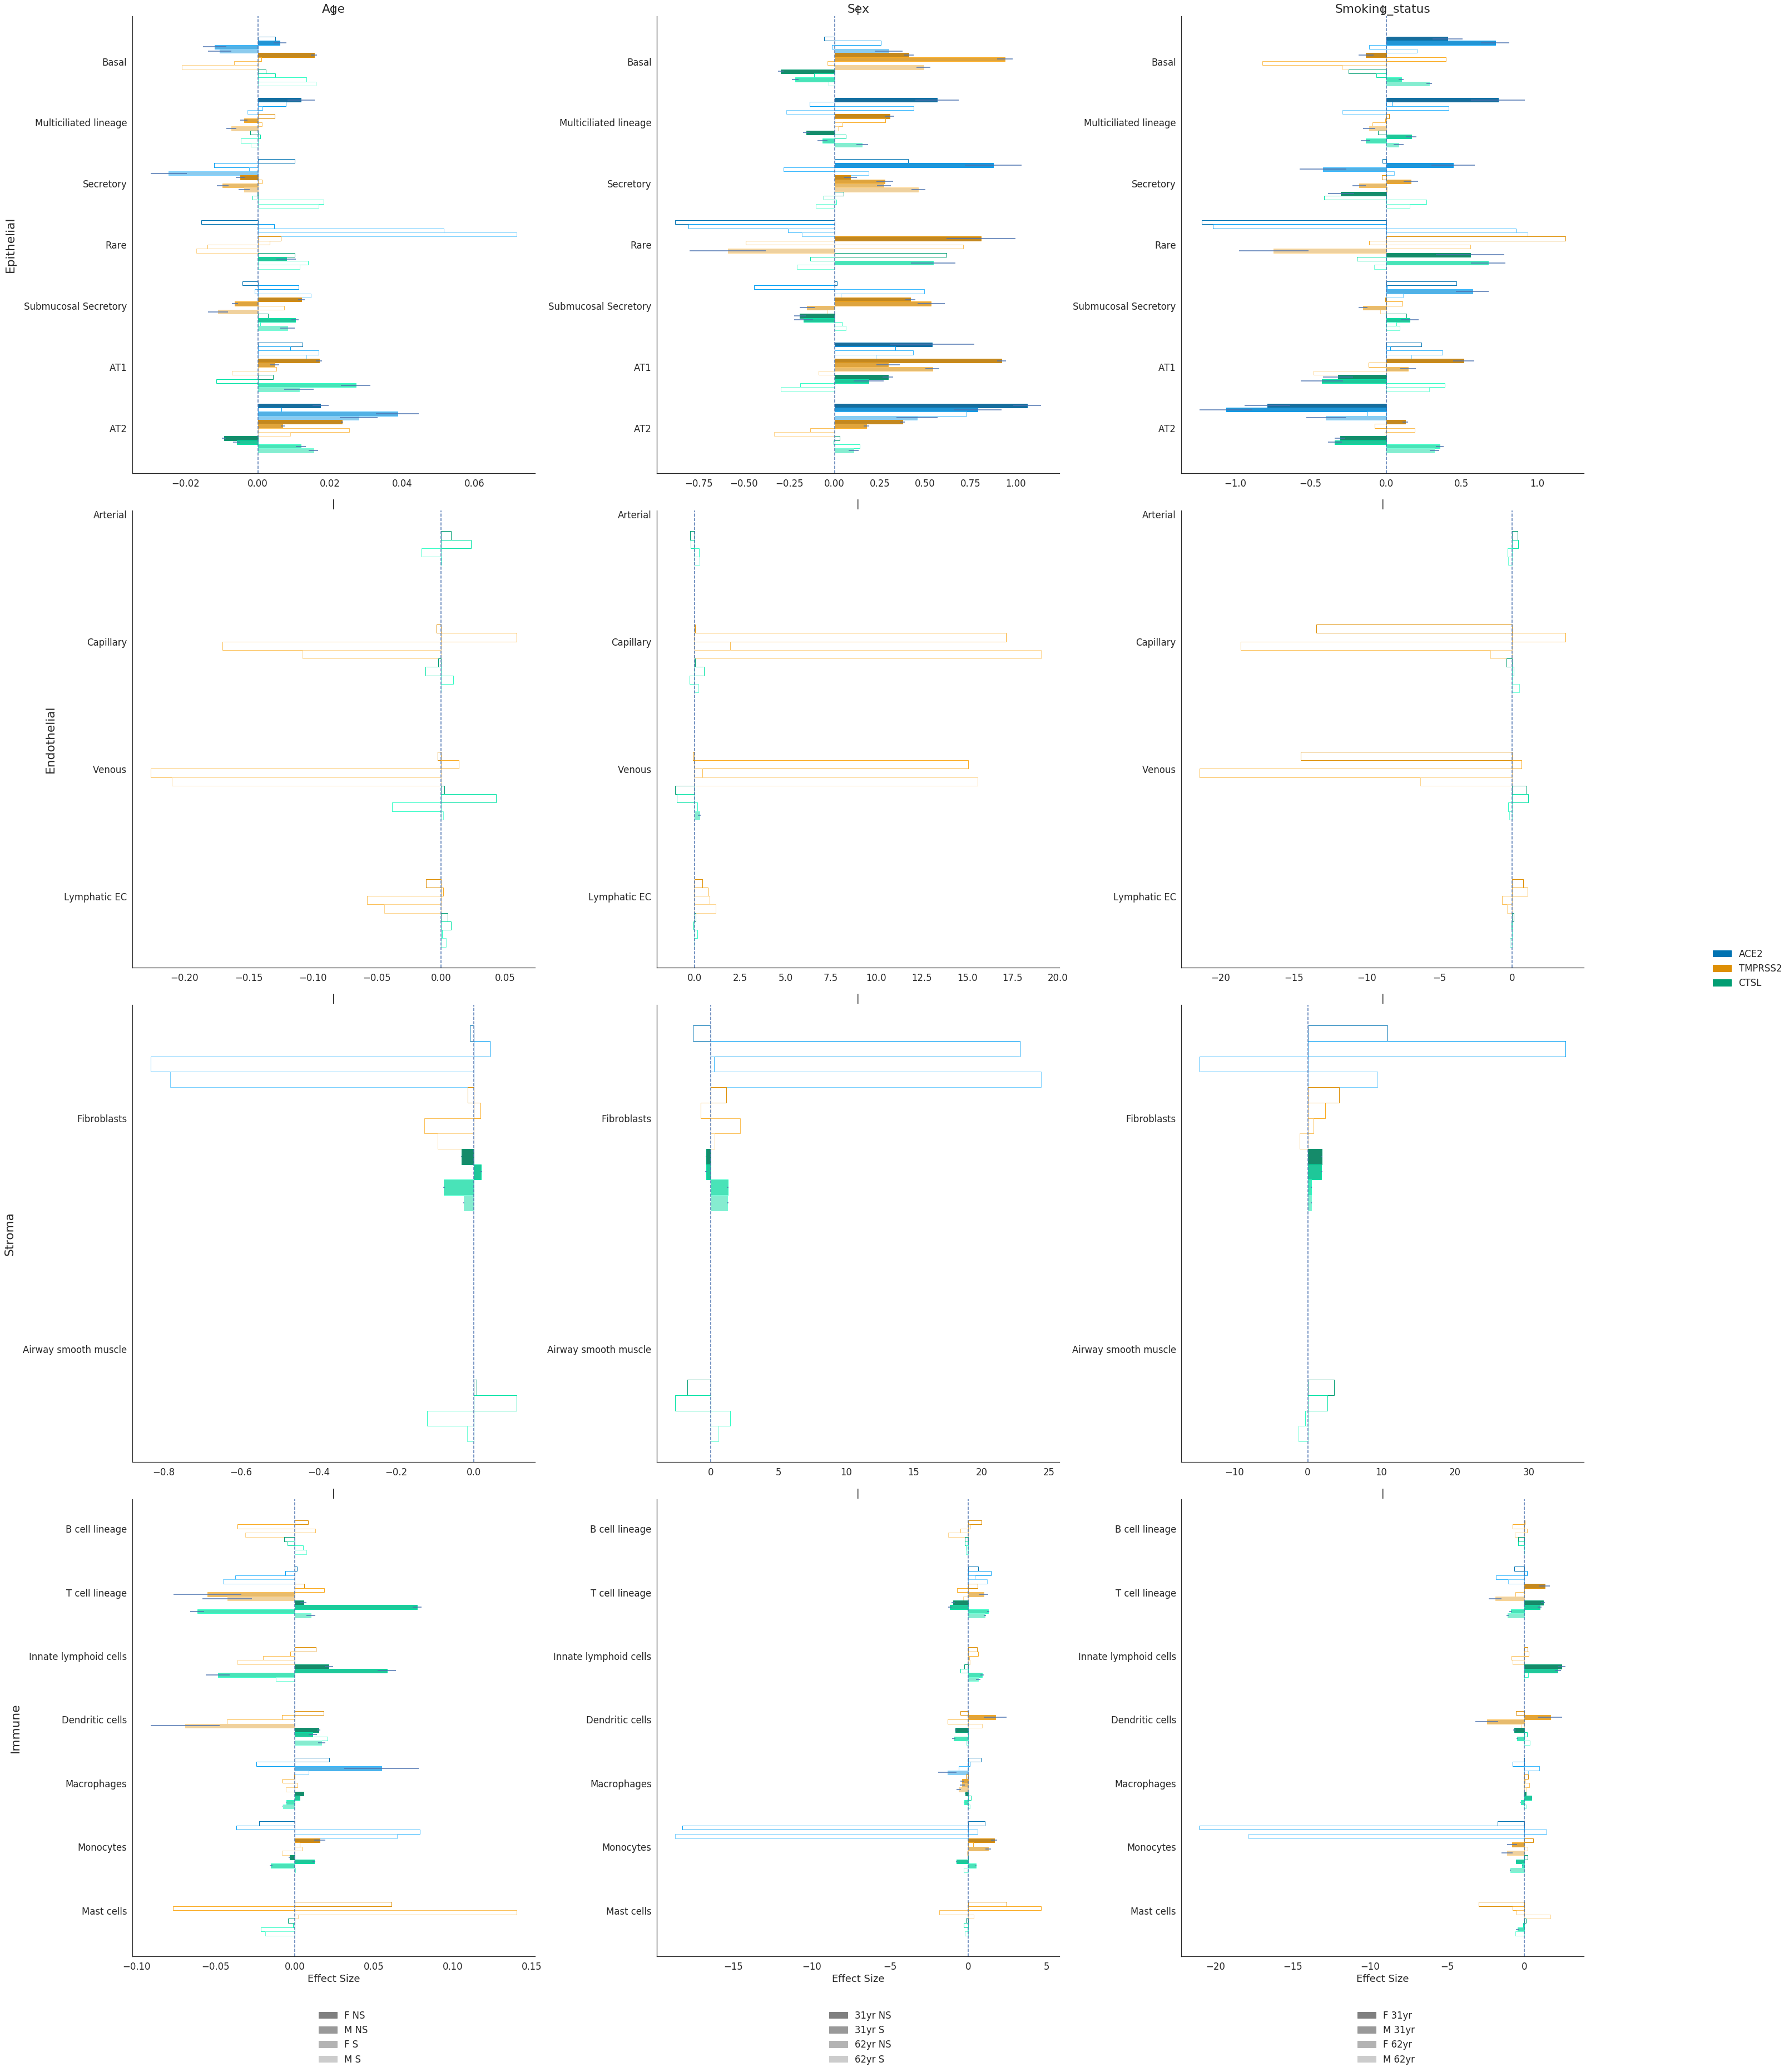

In [13]:
color_base = sns.color_palette('colorblind')[:3]

colors = []
d_alpha = 0.2
for i in range(3):
    for alpha in range(4):
        col = lighten_color(color_base[i], amount=1-(alpha*d_alpha))
        colors.append(col)
    
base_grey = (0.5,0.5,0.5)    
shades = []
d_alpha = 0.2
for alpha in range(4):
    shade = lighten_color(base_grey, amount=1-(alpha*d_alpha))
    shades.append(shade)

gene_order = ['ACE2', 'TMPRSS2', 'CTSL']
gene_eval_order = [' '.join([g, str(i)]) for g in gene_order for i in range(4)]

cat_order = ['Age', 'Sex', 'Smoking_status']
comp_order = ['Epithelial', 'Endothelial', 'Stroma', 'Immune']
hue_col = 'gene_eval'

p1 = sns.catplot(y='cell_identity', x='coef', hue=hue_col, ci=None, kind='bar', col='covariate_simple', row='compartment', sharey='none', sharex='none', orient='h', data=res_lvl3, legend=False, palette=sns.color_palette(colors), hue_order=gene_eval_order)

for j,group in enumerate(p1.axes):
    for i,ax in enumerate(group):
        ax.axvline(0, ls='--')
        tmp = plt.setp(ax.patches, linewidth=1, edgecolor='black')
        
        dat_sub = res_lvl3.loc[(res_lvl3['covariate_simple'] == cat_order[i]) & (res_lvl3['compartment'] == comp_order[j])].copy()
        dat_sub.reset_index(inplace=True, drop=True);
        ct_dict = {ct:idx for idx,ct in enumerate(dat_sub['cell_identity'].unique())}
        bar_width = ax.patches[0].get_height()
        gen_dict = {g:(i-(5.5))*bar_width for i,g in enumerate(gene_eval_order)}
        offset_yloc = res_lvl3.groupby(['compartment'])['cell_identity'].nunique()[comp_order[:j]].sum()
        dat_sub['yloc'] = [offset_yloc+ct_dict[ct]+gen_dict[dat_sub[hue_col][i]] for i,ct in enumerate(dat_sub['cell_identity'])]
        signif = dat_sub['signif_bulk_agree'].values
        ax.errorbar(y=dat_sub['yloc'][signif], x=dat_sub['coef'][signif], xerr=dat_sub['coef_sd'][signif], linestyle='None', marker='None')
        
        for a in ax.patches:

            idx = dat_sub.index[np.isclose(dat_sub['yloc'], a.get_y()+(bar_width/2))]
            if len(idx) == 1:
                g = dat_sub.loc[idx]['gene_eval'].values[0]
                a.set_edgecolor(sns.color_palette(colors)[gene_eval_order.index(g)])
                
                if (~dat_sub.loc[idx]['signif_bulk_agree']).values[0]:
                    a.set_facecolor('white')

p1.set_titles(row_template = '', col_template = '')

p1.set_axis_labels(y_var='', x_var='Effect Size')
p1.fig.set_size_inches(40,50)

for ax, col in zip(p1.axes[0], cat_order):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, 6),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(p1.axes[:,0], comp_order):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 6, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation=90)

plt.subplots_adjust(wspace=0.3)
plt.tight_layout()

#Age legend
age_labs = [j[0] for j in sorted(list(eval_encoding['age'].items()), key=lambda i: i[1])]
age_handles = [patches.Patch(color=shades[i], label=age_labs[i]) for i in range(4)]
leg_age = plt.legend(handles=age_handles, bbox_to_anchor = [-2.0, -0.1], frameon=False, title=None)

#Sex legend
sex_labs = [j[0] for j in sorted(list(eval_encoding['sex[T.male]'].items()), key=lambda i: i[1])]
sex_handles = [patches.Patch(color=shades[i], label=sex_labs[i]) for i in range(4)]
leg_sex = plt.legend(handles=sex_handles, bbox_to_anchor = [-0.7, -0.1], frameon=False, title=None)

#Smoking legend
smoking_labs = [j[0] for j in sorted(list(eval_encoding['smoking_status[T.True]'].items()), key=lambda i: i[1])]
smoking_handles = [patches.Patch(color=shades[i], label=smoking_labs[i]) for i in range(4)]
leg_smoking = plt.legend(handles=smoking_handles, bbox_to_anchor = [0.6, -0.1], frameon=False, title=None)

leg_ace2 = patches.Patch(color=colors[0], label='ACE2')
leg_tmprss2 = patches.Patch(color=colors[4], label='TMPRSS2')
leg_ctsl = patches.Patch(color=colors[8], label='CTSL')
plt.legend(handles=[leg_ace2, leg_tmprss2, leg_ctsl], bbox_to_anchor = [1.3, 2.1], frameon=False, title=None)

plt.gca().add_artist(leg_age)
plt.gca().add_artist(leg_sex)
plt.gca().add_artist(leg_smoking)

plt.savefig(folder+'/'+output_folder+base+'_nUMIoffset_testInts_annlvl3_barplots_lvl1_separated.pdf', dpi=300, bbox_inches='tight')

<ErrorbarContainer object of 3 artists>

(-0.031, 0.045)

<ErrorbarContainer object of 3 artists>

(-0.89, 1.15)

<ErrorbarContainer object of 3 artists>

(-1.25, 1.2)

<ErrorbarContainer object of 3 artists>

(-0.065, 0.061)

<ErrorbarContainer object of 3 artists>

(-1.15, 2.05)

<ErrorbarContainer object of 3 artists>

(-6.35, 3.7)

<ErrorbarContainer object of 3 artists>

(-0.14, 0.122)

<ErrorbarContainer object of 3 artists>

(-2.7, 2.19)

<ErrorbarContainer object of 3 artists>

(-1.5, 4.35)

<ErrorbarContainer object of 3 artists>

(-0.095, 0.142)

<ErrorbarContainer object of 3 artists>

(-1.95, 4.7)

<ErrorbarContainer object of 3 artists>

(-3.3, 2.8)

Text(0, 6, 'Age')

Text(0, 6, 'Sex')

Text(0, 6, 'Smoking_status')

Text(-10.0, 0, 'Epithelial')

Text(-10.0, 0, 'Endothelial')

Text(-10.0, 0, 'Stroma')

Text(-10.0, 0, 'Immune')

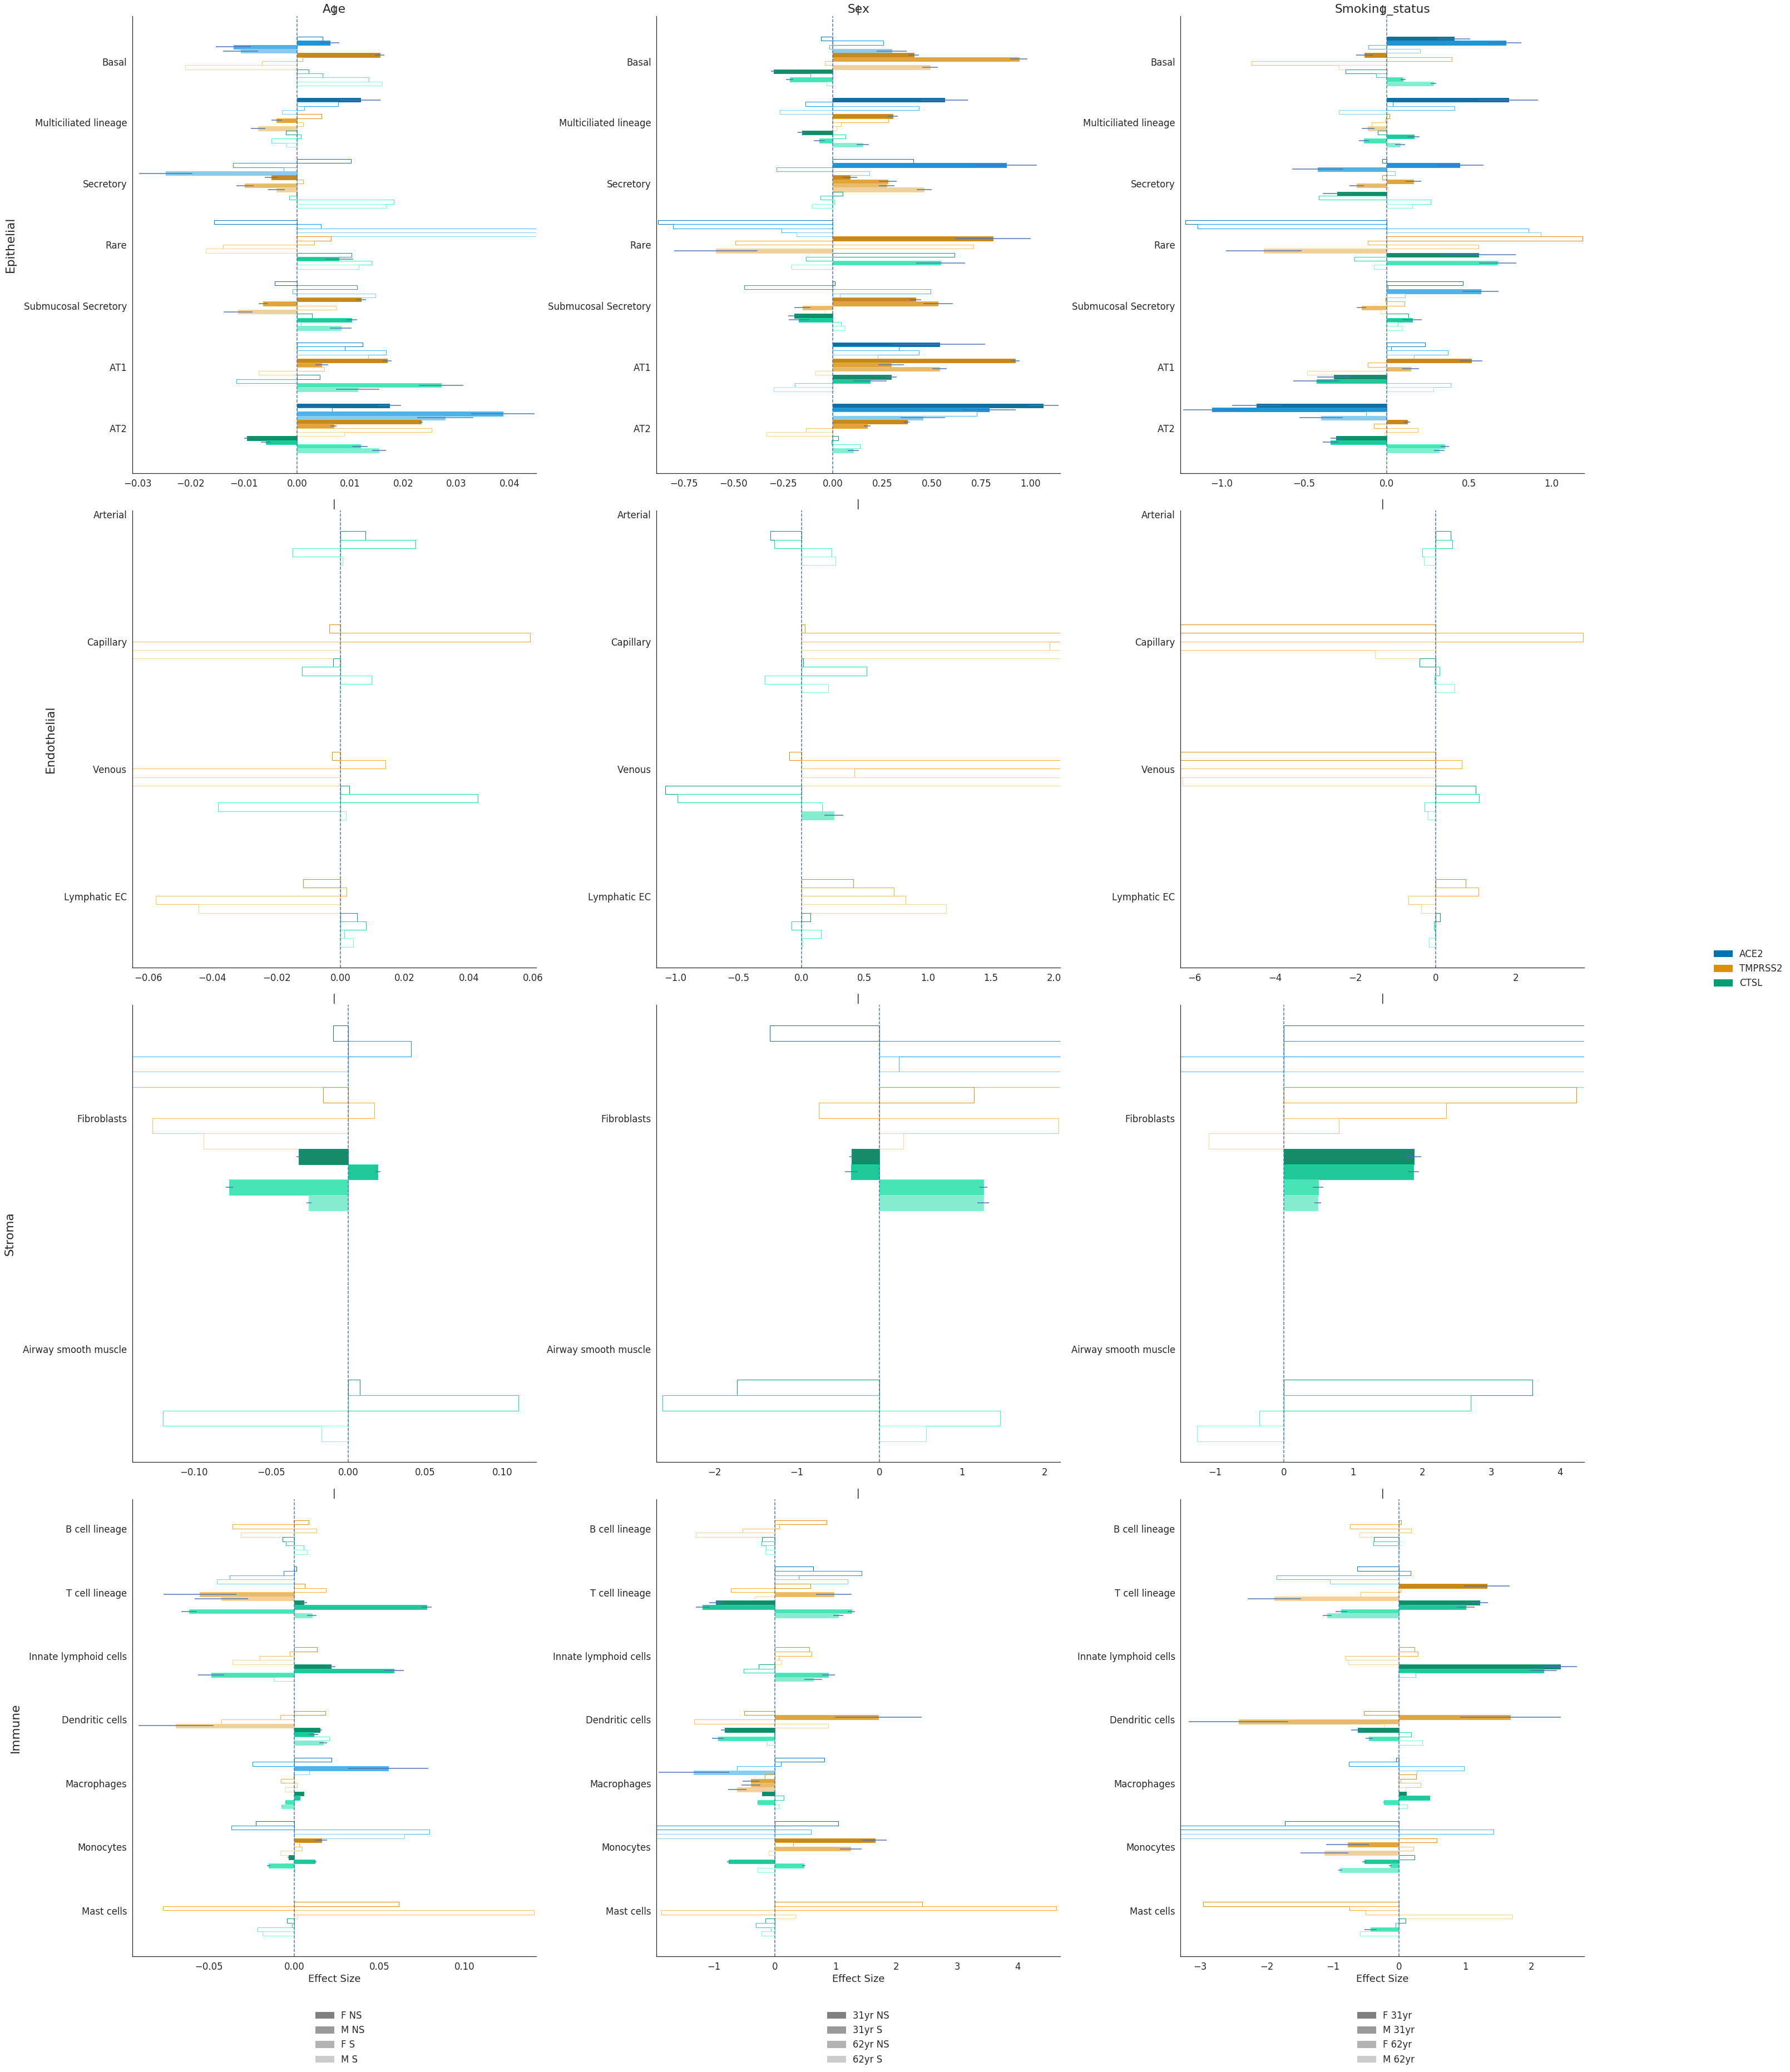

In [14]:
color_base = sns.color_palette('colorblind')[:3]

colors = []
d_alpha = 0.2
for i in range(3):
    for alpha in range(4):
        col = lighten_color(color_base[i], amount=1-(alpha*d_alpha))
        colors.append(col)
    
base_grey = (0.5,0.5,0.5)    
shades = []
d_alpha = 0.2
for alpha in range(4):
    shade = lighten_color(base_grey, amount=1-(alpha*d_alpha))
    shades.append(shade)

gene_order = ['ACE2', 'TMPRSS2', 'CTSL']
gene_eval_order = [' '.join([g, str(i)]) for g in gene_order for i in range(4)]

cat_order = ['Age', 'Sex', 'Smoking_status']
comp_order = ['Epithelial', 'Endothelial', 'Stroma', 'Immune']
hue_col = 'gene_eval'

xlims_top = [[0.045, 1.15, 1.2],
             [0.061, 2.05, 3.7],
             [0.122, 2.19, 4.35],
             [0.142, 4.7, 2.8]]
xlims_bot = [[-0.031, -0.89, -1.25],
             [-0.065,-1.15, -6.35],
             [-0.14, -2.7, -1.5],
             [-0.095, -1.95, -3.3]]

p1 = sns.catplot(y='cell_identity', x='coef', hue=hue_col, ci=None, kind='bar', col='covariate_simple', row='compartment', sharey='none', sharex='none', orient='h', data=res_lvl3, legend=False, palette=sns.color_palette(colors), hue_order=gene_eval_order)

for j,group in enumerate(p1.axes):
    for i,ax in enumerate(group):
        ax.axvline(0, ls='--')
        tmp = plt.setp(ax.patches, linewidth=1, edgecolor='black')
        
        dat_sub = res_lvl3.loc[(res_lvl3['covariate_simple'] == cat_order[i]) & (res_lvl3['compartment'] == comp_order[j])].copy()
        dat_sub.reset_index(inplace=True, drop=True);
        ct_dict = {ct:idx for idx,ct in enumerate(dat_sub['cell_identity'].unique())}
        bar_width = ax.patches[0].get_height()
        gen_dict = {g:(i-(5.5))*bar_width for i,g in enumerate(gene_eval_order)}
        offset_yloc = res_lvl3.groupby(['compartment'])['cell_identity'].nunique()[comp_order[:j]].sum()
        dat_sub['yloc'] = [offset_yloc+ct_dict[ct]+gen_dict[dat_sub[hue_col][i]] for i,ct in enumerate(dat_sub['cell_identity'])]
        signif = dat_sub['signif_bulk_agree'].values
        ax.errorbar(y=dat_sub['yloc'][signif], x=dat_sub['coef'][signif], xerr=dat_sub['coef_sd'][signif], linestyle='None', marker='None')
        
        ax.set_xlim(left=xlims_bot[j][i], right=xlims_top[j][i])
        
        for a in ax.patches:

            idx = dat_sub.index[np.isclose(dat_sub['yloc'], a.get_y()+(bar_width/2))]
            if len(idx) == 1:
                g = dat_sub.loc[idx]['gene_eval'].values[0]
                a.set_edgecolor(sns.color_palette(colors)[gene_eval_order.index(g)])
                
                if (~dat_sub.loc[idx]['signif_bulk_agree']).values[0]:
                    a.set_facecolor('white')

p1.set_titles(row_template = '', col_template = '')

p1.set_axis_labels(y_var='', x_var='Effect Size')
p1.fig.set_size_inches(40,50)

for ax, col in zip(p1.axes[0], cat_order):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, 6),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(p1.axes[:,0], comp_order):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 6, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation=90)

plt.subplots_adjust(wspace=0.3)
plt.tight_layout()

#Age legend
age_labs = [j[0] for j in sorted(list(eval_encoding['age'].items()), key=lambda i: i[1])]
age_handles = [patches.Patch(color=shades[i], label=age_labs[i]) for i in range(4)]
leg_age = plt.legend(handles=age_handles, bbox_to_anchor = [-2.0, -0.1], frameon=False, title=None)

#Sex legend
sex_labs = [j[0] for j in sorted(list(eval_encoding['sex[T.male]'].items()), key=lambda i: i[1])]
sex_handles = [patches.Patch(color=shades[i], label=sex_labs[i]) for i in range(4)]
leg_sex = plt.legend(handles=sex_handles, bbox_to_anchor = [-0.7, -0.1], frameon=False, title=None)

#Smoking legend
smoking_labs = [j[0] for j in sorted(list(eval_encoding['smoking_status[T.True]'].items()), key=lambda i: i[1])]
smoking_handles = [patches.Patch(color=shades[i], label=smoking_labs[i]) for i in range(4)]
leg_smoking = plt.legend(handles=smoking_handles, bbox_to_anchor = [0.6, -0.1], frameon=False, title=None)

leg_ace2 = patches.Patch(color=colors[0], label='ACE2')
leg_tmprss2 = patches.Patch(color=colors[4], label='TMPRSS2')
leg_ctsl = patches.Patch(color=colors[8], label='CTSL')
plt.legend(handles=[leg_ace2, leg_tmprss2, leg_ctsl], bbox_to_anchor = [1.3, 2.1], frameon=False, title=None)

plt.gca().add_artist(leg_age)
plt.gca().add_artist(leg_sex)
plt.gca().add_artist(leg_smoking)

plt.savefig(folder+'/'+output_folder+base+'_nUMIoffset_testInts_annlvl3_barplots_lvl1_separated_lim.pdf', dpi=300, bbox_inches='tight')

In [15]:
res_lvl3.sort_values(by=['cell_identity', 'covariate', 'gene'])

,gene,cell_identity,covariate,eval_at,coef,coef_sd,pval,adj_pvals,compartment,signif_bulk_agree,covariate_simple,eval_num,gene_eval
Basal_age_ACE2_M_NS,ACE2,Basal,age,M NS,0.006132,0.001808,6.925003e-04,1.038751e-03,Epithelial,True,Age,1,ACE2 1
Basal_age_ACE2_F_S,ACE2,Basal,age,F S,-0.011966,0.003272,2.550366e-04,3.991877e-04,Epithelial,True,Age,2,ACE2 2
Basal_age_ACE2_F_NS,ACE2,Basal,age,F NS,0.004779,0.002113,2.371321e-02,2.845585e-02,Epithelial,False,Age,0,ACE2 0
Basal_age_ACE2_M_S,ACE2,Basal,age,M S,-0.010613,0.003261,1.134809e-03,1.634125e-03,Epithelial,True,Age,3,ACE2 3
Basal_age_CTSL_M_S,CTSL,Basal,age,M S,0.016055,0.000876,0.000000e+00,0.000000e+00,Epithelial,False,Age,3,CTSL 3
Basal_age_CTSL_M_NS,CTSL,Basal,age,M NS,0.004805,0.000418,0.000000e+00,0.000000e+00,Epithelial,False,Age,1,CTSL 1
Basal_age_CTSL_F_S,CTSL,Basal,age,F S,0.013457,0.000803,0.000000e+00,0.000000e+00,Epithelial,False,Age,2,CTSL 2
Basal_age_CTSL_F_NS,CTSL,Basal,age,F NS,0.002207,0.000446,7.468782e-07,1.415138e-06,Epithelial,False,Age,0,CTSL 0
Basal_age_TMPRSS2_F_NS,TMPRSS2,Basal,age,F NS,0.015555,0.000868,0.000000e+00,0.000000e+00,Epithelial,True,Age,0,TMPRSS2 0
Basal_age_TMPRSS2_M_NS,TMPRSS2,Basal,age,M NS,0.001054,0.000637,9.770053e-02,1.099131e-01,Epithelial,False,Age,1,TMPRSS2 1


## Level 2

In [16]:
res_lvl2['cell_identity'].unique()

array(['Myeloid', 'Airway epithelium', 'Alveolar epithelium', 'Lymphoid',
       'Fibroblast lineage', 'Blood vessels', 'Submucosal Gland',
       'Smooth Muscle', 'Lymphatics', 'Mesothelium'], dtype=object)

In [17]:
# Prep plotting

# Order cell identity category
res_lvl2['cell_identity'] = res_lvl2['cell_identity'].astype('category').cat.set_categories(['Airway epithelium', 'Submucosal Gland', 'Alveolar epithelium', 'Blood vessels', 'Lymphatics', 'Fibroblast lineage', 'Smooth Muscle', 'Mesothelium', 'Lymphoid', 'Myeloid'], ordered=True)
res_lvl2 = res_lvl2.sort_values(by='cell_identity')

# Create hierarchy of cell identities
ct_hierarchy = {'Epithelial':['Airway epithelium', 'Submucosal Gland', 'Alveolar epithelium'], 'Endothelial':['Blood vessels', 'Lymphatics'], 'Stroma':['Fibroblast lineage', 'Smooth Muscle', 'Mesothelium'], 'Immune':['Lymphoid', 'Myeloid']}
ct_mapping_up = dict()
for key,val in ct_hierarchy.items():
    for v in val:
        ct_mapping_up[v] = key

# Assign cell type compartment covariate
res_lvl2['compartment'] = [ct_mapping_up[ct] for ct in res_lvl2['cell_identity']]        

# Check if bulk and sc effect directions agree
res_lvl2_pseudo.index = ['_'.join(vals).replace(' ','_') for vals in res_lvl2_pseudo[['cell_identity', 'covariate', 'gene', 'eval_at']].values.tolist()]
res_lvl2.index = ['_'.join(vals).replace(' ', '_') for vals in res_lvl2[['cell_identity', 'covariate', 'gene', 'eval_at']].values.tolist()]
res_lvl2['signif_bulk_agree'] = [(val < 0.05) and ((res_lvl2['coef'].loc[res_lvl2.index[i]]* res_lvl2_pseudo['coef'].loc[res_lvl2.index[i]]) > 0) for i,val in enumerate(res_lvl2['adj_pvals'])]


res_lvl2['compartment'] = res_lvl2['compartment'].astype('category').cat.set_categories(['Epithelial', 'Endothelial', 'Stroma', 'Immune'], ordered=True)
res_lvl2['covariate_simple'] = res_lvl2['covariate'].astype('category').cat.rename_categories(['Age', 'Sex', 'Smoking_status'])

# Assign eval_at numbers
res_lvl2 = res_lvl2.sort_values(by=['cell_identity', 'covariate', 'gene'])

eval_encoding = {
    'age':{'F NS':0, 'M NS':1, 'F S':2, 'M S':3},
    'sex[T.male]':{'31yr NS':0, '31yr S':1, '62yr NS':2, '62yr S':3},
    'smoking_status[T.True]':{'F 31yr':0, 'M 31yr':1, 'F 62yr':2, 'M 62yr':3}
}

res_lvl2['eval_num'] = [eval_encoding[res_lvl2['covariate'].loc[idx]][res_lvl2['eval_at'].loc[idx]] 
                        for idx in res_lvl2.index]

res_lvl2['gene_eval'] = [' '.join([i,str(j)]) for i,j in zip(res_lvl2['gene'], res_lvl2['eval_num'])]

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

Text(0, 6, 'Age')

Text(0, 6, 'Sex')

Text(0, 6, 'Smoking_status')

Text(-10.0, 0, 'Epithelial')

Text(-10.0, 0, 'Endothelial')

Text(-10.0, 0, 'Stroma')

Text(-10.0, 0, 'Immune')

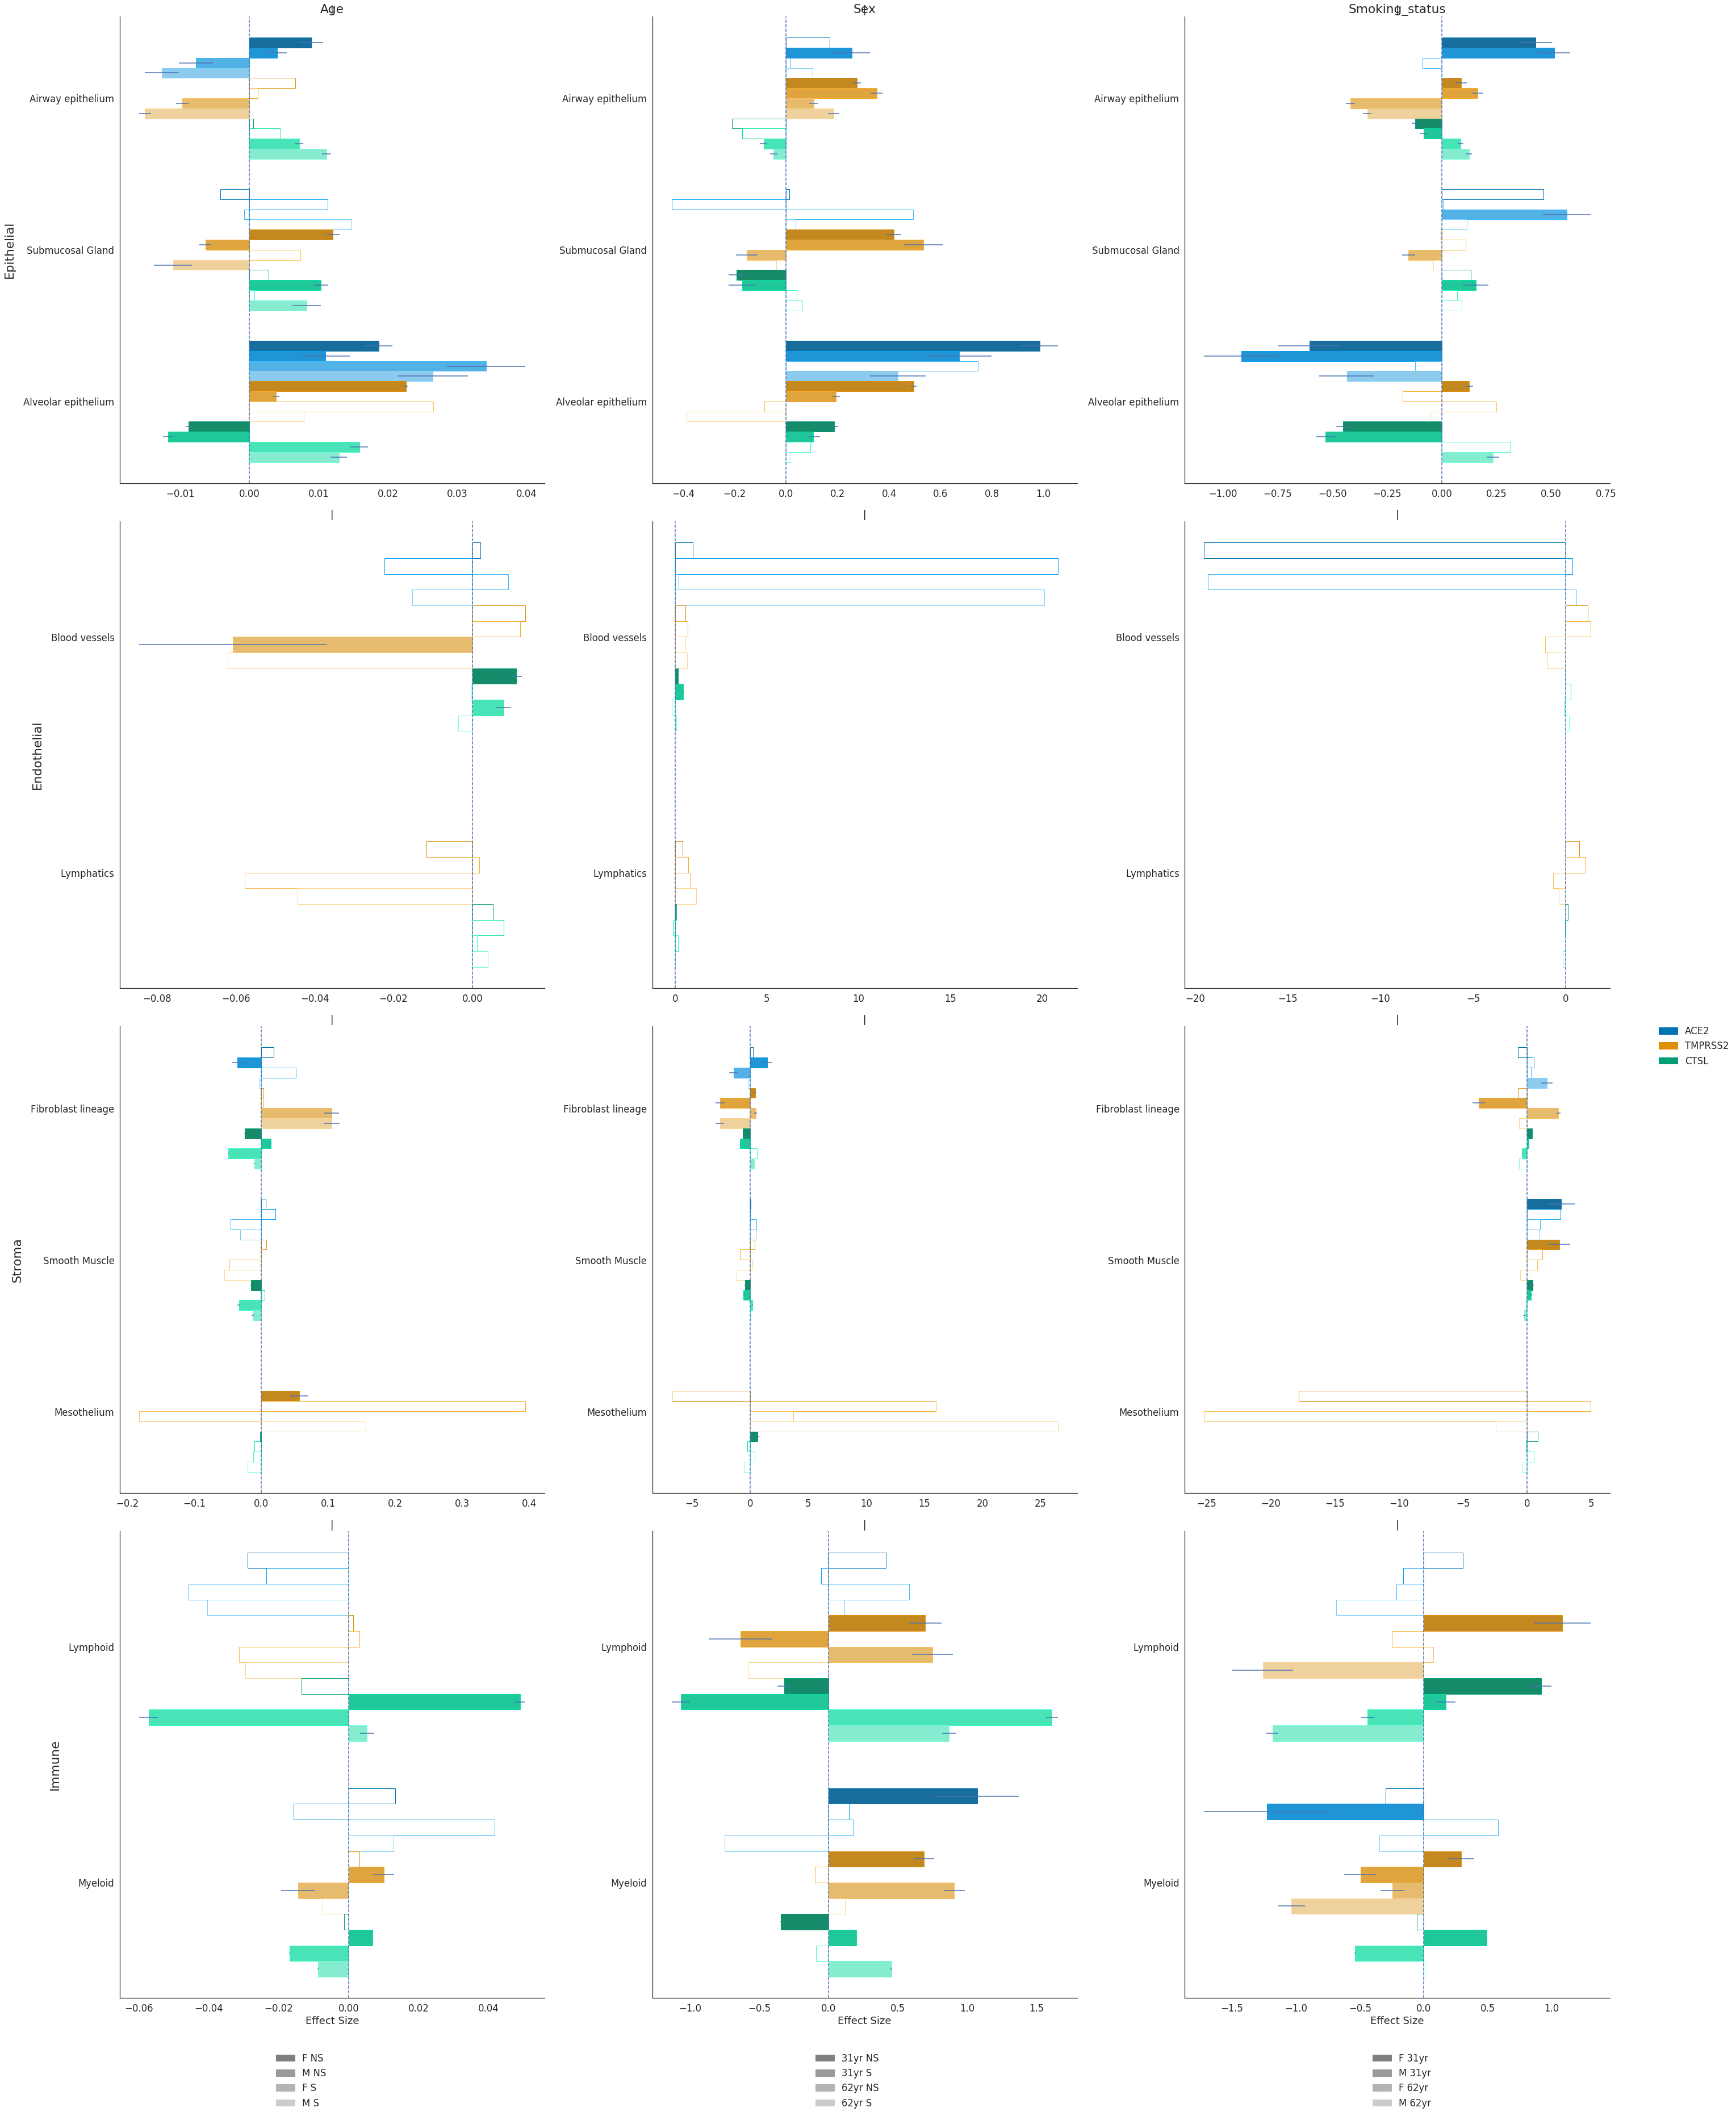

In [18]:
color_base = sns.color_palette('colorblind')[:3]

colors = []
d_alpha = 0.2
for i in range(3):
    for alpha in range(4):
        col = lighten_color(color_base[i], amount=1-(alpha*d_alpha))
        colors.append(col)
    
base_grey = (0.5,0.5,0.5)    
shades = []
d_alpha = 0.2
for alpha in range(4):
    shade = lighten_color(base_grey, amount=1-(alpha*d_alpha))
    shades.append(shade)

gene_order = ['ACE2', 'TMPRSS2', 'CTSL']
gene_eval_order = [' '.join([g, str(i)]) for g in gene_order for i in range(4)]

cat_order = ['Age', 'Sex', 'Smoking_status']
comp_order = ['Epithelial', 'Endothelial', 'Stroma', 'Immune']
hue_col = 'gene_eval'

p1 = sns.catplot(y='cell_identity', x='coef', hue=hue_col, ci=None, kind='bar', col='covariate_simple', row='compartment', sharey='none', sharex='none', orient='h', data=res_lvl2, legend=False, palette=sns.color_palette(colors), hue_order=gene_eval_order)

for j,group in enumerate(p1.axes):
    for i,ax in enumerate(group):
        ax.axvline(0, ls='--')
        tmp = plt.setp(ax.patches, linewidth=1, edgecolor='black')
        
        dat_sub = res_lvl2.loc[(res_lvl2['covariate_simple'] == cat_order[i]) & (res_lvl2['compartment'] == comp_order[j])].copy()
        dat_sub.reset_index(inplace=True, drop=True);
        ct_dict = {ct:idx for idx,ct in enumerate(dat_sub['cell_identity'].unique())}
        bar_width = ax.patches[0].get_height()
        gen_dict = {g:(i-(5.5))*bar_width for i,g in enumerate(gene_eval_order)}
        offset_yloc = res_lvl2.groupby(['compartment'])['cell_identity'].nunique()[comp_order[:j]].sum()
        dat_sub['yloc'] = [offset_yloc+ct_dict[ct]+gen_dict[dat_sub[hue_col][i]] for i,ct in enumerate(dat_sub['cell_identity'])]
        signif = dat_sub['signif_bulk_agree'].values
        ax.errorbar(y=dat_sub['yloc'][signif], x=dat_sub['coef'][signif], xerr=dat_sub['coef_sd'][signif], linestyle='None', marker='None')
        
        for a in ax.patches:

            idx = dat_sub.index[np.isclose(dat_sub['yloc'], a.get_y()+(bar_width/2))]
            if len(idx) == 1:
                g = dat_sub.loc[idx]['gene_eval'].values[0]
                a.set_edgecolor(sns.color_palette(colors)[gene_eval_order.index(g)])
                
                if (~dat_sub.loc[idx]['signif_bulk_agree']).values[0]:
                    a.set_facecolor('white')

p1.set_titles(row_template = '', col_template = '')

p1.set_axis_labels(y_var='', x_var='Effect Size')
p1.fig.set_size_inches(40,50)

for ax, col in zip(p1.axes[0], cat_order):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, 6),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(p1.axes[:,0], comp_order):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 6, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation=90)

plt.subplots_adjust(wspace=0.3)
plt.tight_layout()

#Age legend
age_labs = [j[0] for j in sorted(list(eval_encoding['age'].items()), key=lambda i: i[1])]
age_handles = [patches.Patch(color=shades[i], label=age_labs[i]) for i in range(4)]
leg_age = plt.legend(handles=age_handles, bbox_to_anchor = [-2.0, -0.1], frameon=False, title=None)

#Sex legend
sex_labs = [j[0] for j in sorted(list(eval_encoding['sex[T.male]'].items()), key=lambda i: i[1])]
sex_handles = [patches.Patch(color=shades[i], label=sex_labs[i]) for i in range(4)]
leg_sex = plt.legend(handles=sex_handles, bbox_to_anchor = [-0.7, -0.1], frameon=False, title=None)

#Smoking legend
smoking_labs = [j[0] for j in sorted(list(eval_encoding['smoking_status[T.True]'].items()), key=lambda i: i[1])]
smoking_handles = [patches.Patch(color=shades[i], label=smoking_labs[i]) for i in range(4)]
leg_smoking = plt.legend(handles=smoking_handles, bbox_to_anchor = [0.6, -0.1], frameon=False, title=None)

leg_ace2 = patches.Patch(color=colors[0], label='ACE2')
leg_tmprss2 = patches.Patch(color=colors[4], label='TMPRSS2')
leg_ctsl = patches.Patch(color=colors[8], label='CTSL')
plt.legend(handles=[leg_ace2, leg_tmprss2, leg_ctsl], bbox_to_anchor = [1.3, 2.1], frameon=False, title=None)

plt.gca().add_artist(leg_age)
plt.gca().add_artist(leg_sex)
plt.gca().add_artist(leg_smoking)

plt.savefig(folder+'/'+output_folder+base+'_nUMIoffset_testInts_annlvl2_barplots_lvl1_separated.pdf', dpi=300, bbox_inches='tight')

In [19]:
res_lvl2.sort_values(by=[ 'covariate', 'cell_identity',  'gene'])

,gene,cell_identity,covariate,eval_at,coef,coef_sd,pval,adj_pvals,compartment,signif_bulk_agree,covariate_simple,eval_num,gene_eval
Airway_epithelium_age_ACE2_F_NS,ACE2,Airway epithelium,age,F NS,0.008869,0.001747,3.861422e-07,6.043965e-07,Epithelial,True,Age,0,ACE2 0
Airway_epithelium_age_ACE2_F_S,ACE2,Airway epithelium,age,F S,-0.007782,0.002456,1.533047e-03,1.971060e-03,Epithelial,True,Age,2,ACE2 2
Airway_epithelium_age_ACE2_M_NS,ACE2,Airway epithelium,age,M NS,0.003985,0.001433,5.420012e-03,6.504015e-03,Epithelial,True,Age,1,ACE2 1
Airway_epithelium_age_ACE2_M_S,ACE2,Airway epithelium,age,M S,-0.012666,0.002478,3.212723e-07,5.257183e-07,Epithelial,True,Age,3,ACE2 3
Airway_epithelium_age_CTSL_F_NS,CTSL,Airway epithelium,age,F NS,0.000510,0.000363,1.601328e-01,1.695524e-01,Epithelial,False,Age,0,CTSL 0
Airway_epithelium_age_CTSL_M_NS,CTSL,Airway epithelium,age,M NS,0.004456,0.000344,0.000000e+00,0.000000e+00,Epithelial,False,Age,1,CTSL 1
Airway_epithelium_age_CTSL_F_S,CTSL,Airway epithelium,age,F S,0.007145,0.000618,0.000000e+00,0.000000e+00,Epithelial,True,Age,2,CTSL 2
Airway_epithelium_age_CTSL_M_S,CTSL,Airway epithelium,age,M S,0.011092,0.000650,0.000000e+00,0.000000e+00,Epithelial,True,Age,3,CTSL 3
Airway_epithelium_age_TMPRSS2_F_NS,TMPRSS2,Airway epithelium,age,F NS,0.006597,0.000516,0.000000e+00,0.000000e+00,Epithelial,False,Age,0,TMPRSS2 0
Airway_epithelium_age_TMPRSS2_F_S,TMPRSS2,Airway epithelium,age,F S,-0.009708,0.000885,0.000000e+00,0.000000e+00,Epithelial,True,Age,2,TMPRSS2 2


<ErrorbarContainer object of 3 artists>

(-0.01875014535473571, 0.04265782891058251)

<ErrorbarContainer object of 3 artists>

(-0.5201315036636309, 1.1310905174057635)

<ErrorbarContainer object of 3 artists>

(-1.1753694888924895, 0.767282121799882)

<ErrorbarContainer object of 3 artists>

(-0.08943513159283921, 0.018369905771755807)

<ErrorbarContainer object of 3 artists>

(-1.2409092843495075, 1.25)

<ErrorbarContainer object of 3 artists>

(-3.2, 2.3757172304810714)

<ErrorbarContainer object of 3 artists>

(-0.058, 0.122)

<ErrorbarContainer object of 3 artists>

(-3.05, 2.0)

<ErrorbarContainer object of 3 artists>

(-4.5, 6.45891399774852)

<ErrorbarContainer object of 3 artists>

(-0.06541878039750679, 0.056021610078460064)

<ErrorbarContainer object of 3 artists>

(-1.2732048063396193, 1.7954974325289956)

<ErrorbarContainer object of 3 artists>

(-1.8712348362300557, 1.4531056357131844)

Text(0, 6, 'Age')

Text(0, 6, 'Sex')

Text(0, 6, 'Smoking_status')

Text(-10.0, 0, 'Epithelial')

Text(-10.0, 0, 'Endothelial')

Text(-10.0, 0, 'Stroma')

Text(-10.0, 0, 'Immune')

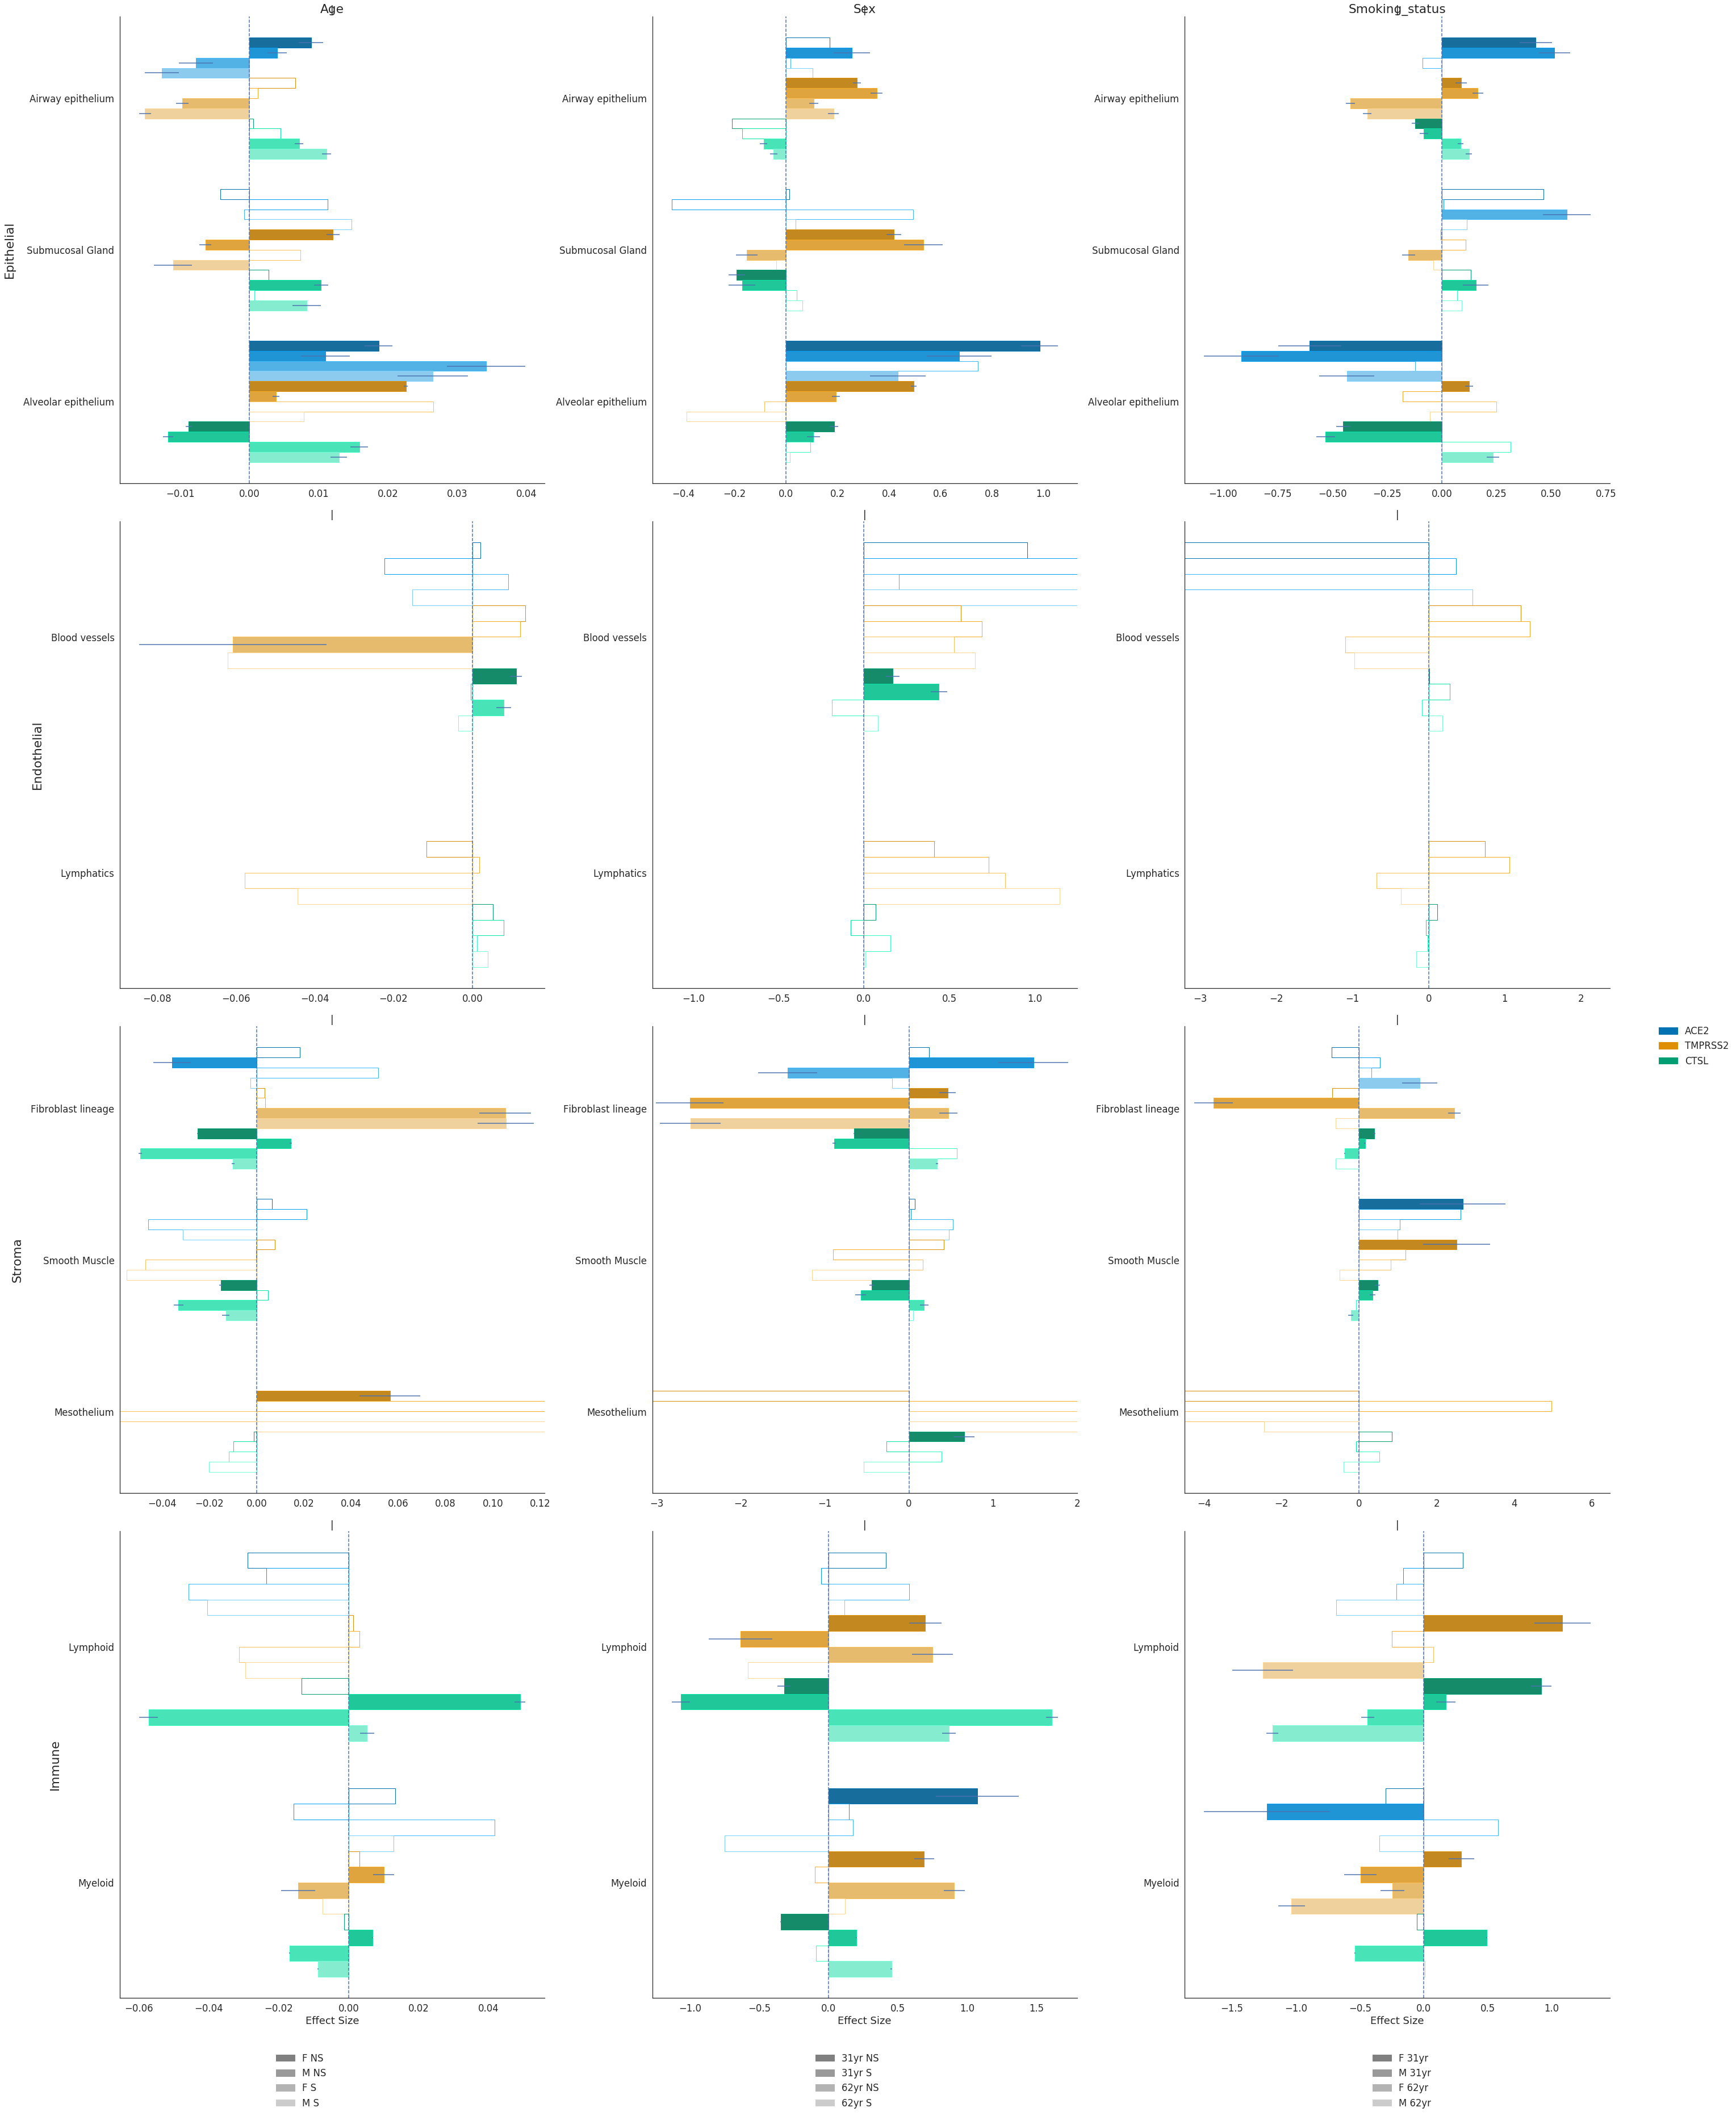

In [20]:
color_base = sns.color_palette('colorblind')[:3]

colors = []
d_alpha = 0.2
for i in range(3):
    for alpha in range(4):
        col = lighten_color(color_base[i], amount=1-(alpha*d_alpha))
        colors.append(col)
    
base_grey = (0.5,0.5,0.5)    
shades = []
d_alpha = 0.2
for alpha in range(4):
    shade = lighten_color(base_grey, amount=1-(alpha*d_alpha))
    shades.append(shade)

gene_order = ['ACE2', 'TMPRSS2', 'CTSL']
gene_eval_order = [' '.join([g, str(i)]) for g in gene_order for i in range(4)]

cat_order = ['Age', 'Sex', 'Smoking_status']
comp_order = ['Epithelial', 'Endothelial', 'Stroma', 'Immune']
hue_col = 'gene_eval'

xlims_top = [[None, None, None],
             [None, 1.25, None],
             [0.122, 2.0, None],
             [None, None, None]]
xlims_bot = [[None, None, None],
             [None, None, -3.2],
             [-0.058, -3.05, -4.5],
             [None, None, None]]

p1 = sns.catplot(y='cell_identity', x='coef', hue=hue_col, ci=None, kind='bar', col='covariate_simple', row='compartment', sharey='none', sharex='none', orient='h', data=res_lvl2, legend=False, palette=sns.color_palette(colors), hue_order=gene_eval_order)

for j,group in enumerate(p1.axes):
    for i,ax in enumerate(group):
        ax.axvline(0, ls='--')
        tmp = plt.setp(ax.patches, linewidth=1, edgecolor='black')
        
        dat_sub = res_lvl2.loc[(res_lvl2['covariate_simple'] == cat_order[i]) & (res_lvl2['compartment'] == comp_order[j])].copy()
        dat_sub.reset_index(inplace=True, drop=True);
        ct_dict = {ct:idx for idx,ct in enumerate(dat_sub['cell_identity'].unique())}
        bar_width = ax.patches[0].get_height()
        gen_dict = {g:(i-(5.5))*bar_width for i,g in enumerate(gene_eval_order)}
        offset_yloc = res_lvl2.groupby(['compartment'])['cell_identity'].nunique()[comp_order[:j]].sum()
        dat_sub['yloc'] = [offset_yloc+ct_dict[ct]+gen_dict[dat_sub[hue_col][i]] for i,ct in enumerate(dat_sub['cell_identity'])]
        signif = dat_sub['signif_bulk_agree'].values
        ax.errorbar(y=dat_sub['yloc'][signif], x=dat_sub['coef'][signif], xerr=dat_sub['coef_sd'][signif], linestyle='None', marker='None')
        
        ax.set_xlim(left=xlims_bot[j][i], right=xlims_top[j][i])
        
        for a in ax.patches:

            idx = dat_sub.index[np.isclose(dat_sub['yloc'], a.get_y()+(bar_width/2))]
            if len(idx) == 1:
                g = dat_sub.loc[idx]['gene_eval'].values[0]
                a.set_edgecolor(sns.color_palette(colors)[gene_eval_order.index(g)])
                
                if (~dat_sub.loc[idx]['signif_bulk_agree']).values[0]:
                    a.set_facecolor('white')

p1.set_titles(row_template = '', col_template = '')

p1.set_axis_labels(y_var='', x_var='Effect Size')
p1.fig.set_size_inches(40,50)

for ax, col in zip(p1.axes[0], cat_order):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, 6),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(p1.axes[:,0], comp_order):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 6, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation=90)

plt.subplots_adjust(wspace=0.3)
plt.tight_layout()

#Age legend
age_labs = [j[0] for j in sorted(list(eval_encoding['age'].items()), key=lambda i: i[1])]
age_handles = [patches.Patch(color=shades[i], label=age_labs[i]) for i in range(4)]
leg_age = plt.legend(handles=age_handles, bbox_to_anchor = [-2.0, -0.1], frameon=False, title=None)

#Sex legend
sex_labs = [j[0] for j in sorted(list(eval_encoding['sex[T.male]'].items()), key=lambda i: i[1])]
sex_handles = [patches.Patch(color=shades[i], label=sex_labs[i]) for i in range(4)]
leg_sex = plt.legend(handles=sex_handles, bbox_to_anchor = [-0.7, -0.1], frameon=False, title=None)

#Smoking legend
smoking_labs = [j[0] for j in sorted(list(eval_encoding['smoking_status[T.True]'].items()), key=lambda i: i[1])]
smoking_handles = [patches.Patch(color=shades[i], label=smoking_labs[i]) for i in range(4)]
leg_smoking = plt.legend(handles=smoking_handles, bbox_to_anchor = [0.6, -0.1], frameon=False, title=None)

leg_ace2 = patches.Patch(color=colors[0], label='ACE2')
leg_tmprss2 = patches.Patch(color=colors[4], label='TMPRSS2')
leg_ctsl = patches.Patch(color=colors[8], label='CTSL')
plt.legend(handles=[leg_ace2, leg_tmprss2, leg_ctsl], bbox_to_anchor = [1.3, 2.1], frameon=False, title=None)

plt.gca().add_artist(leg_age)
plt.gca().add_artist(leg_sex)
plt.gca().add_artist(leg_smoking)

plt.savefig(folder+'/'+output_folder+base+'_nUMIoffset_testInts_annlvl2_barplots_lvl1_separated_lim.pdf', dpi=300, bbox_inches='tight')